# NAO example notebook

This notebook contains an example of data access of ERA5 data with the `intake_reader` and evaluation of the NAO teleconnection (station based index) with aqua libraries and an example of the plotting routines.

In [1]:
import datetime
import sys
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from index import *
from plots import *
from tools import *

sys.path.insert(0, '../../')
from aqua import Reader

## Teleconnection and machine details configuration

Details such as teleconnection coordinates, folder input/output are obtained with functions collected in the `tools.py` file, that access details from a `yaml` file.
Machine needs to be specified if working on `wilma` that does not access data with the `intake_reader`.
The function `load_namelist` instead contains data such as coordinates that are specific of the choosen teleconnection.
Details about the NAO teleconnection can be accessed by specificing the teleconnection name as a string.

In [2]:
machine   = 'levante'
diagname  = 'teleconnections'
telecname = 'NAO'
exp       = 'ERA5'

config   = load_config(machine)
namelist = load_namelist(diagname)

field = config[diagname][telecname][exp]['var']

`config` and `namelist` contain now the detail about the machine and the teleconnections diagnostic.

## Retrieve data with the intake AQUA functionality

In [3]:
configdir = '../../config/'

reader = Reader(model='ERA5',exp='era5',source='monthly_inst',configdir=configdir,regrid='r100')

In [4]:
data = reader.retrieve()

/work/bb1153/b382289/mambaforge/envs/teleconnections/lib/python3.10/site-packages/intake_esm/utils.py:96: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(catalog_path, **csv_kwargs), catalog_path


### Regrid

With the values already specified in the reader instance it is possible to select the data for the desired variable with the desired regrid.

In [5]:
infile = data[field]
infile = reader.regrid(infile)

## Index evaluation

The NAO index can be evaluated by using the library function `station_based_index` from the `index.py` file.

The index can be evaluated with a custom rolling window to average data (standard is 3 months).

In [6]:
nao = station_based_index(infile,namelist,telecname,months_window=3)

/work/bb1153/b382289/mambaforge/envs/teleconnections/lib/python3.10/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


Index time serie is returned as a DataArray.

The time serie can be plot with the `index_plot` function from the `plots.py` file.

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'NAO index'}, xlabel='time', ylabel='index'>)

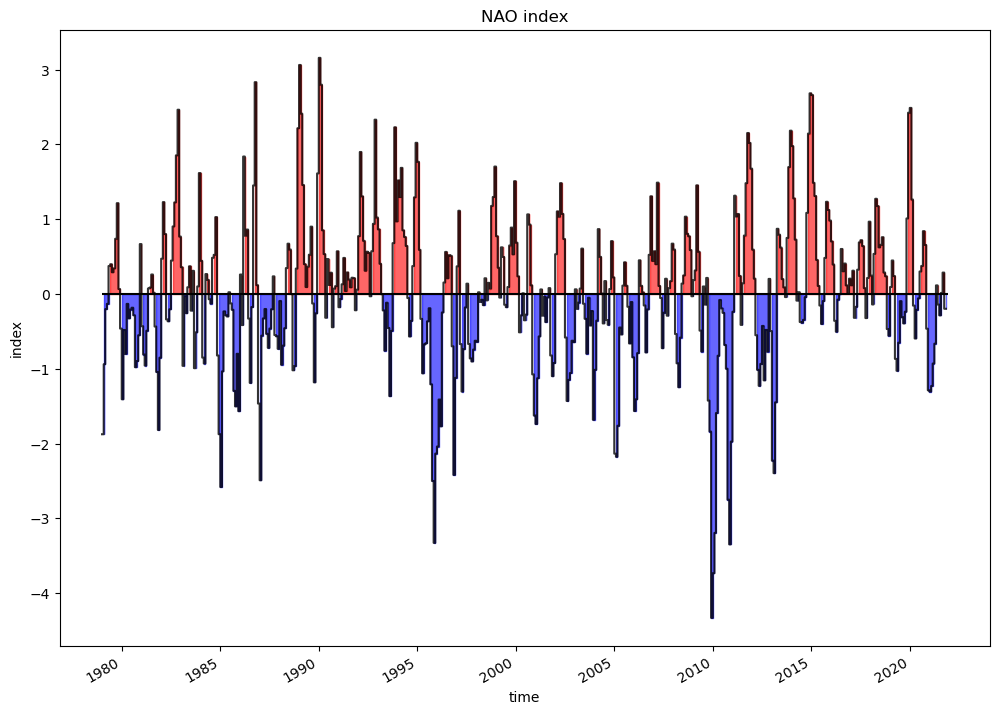

In [9]:
index_plot(nao,title='NAO index',save=True,filename='NAO_index.png',outputdir='img/',xlabel='time')

## Regression plot

To visualize the teleconnection on a 2D plot functions in the `plots.py` are introduced.
There is an option `plot=True` that creates a plot of the regression. Additionally an xarray containing the result of the regression is returned.

(<xarray.DataArray (lat: 180, lon: 360)>
 dask.array<truediv, shape=(180, 360), dtype=float64, chunksize=(180, 360), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
   * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0,
 <Figure size 800x400 with 2 Axes>,
 <GeoAxes: title={'center': 'NAO index'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

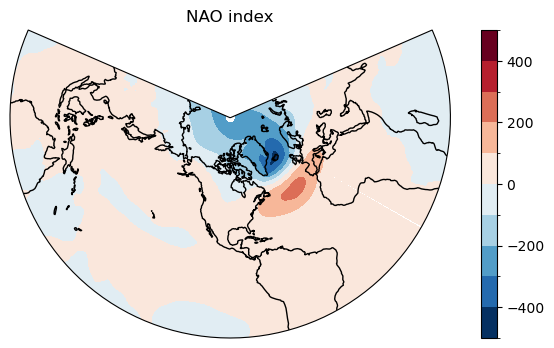

In [10]:
reg_plot(nao,infile,save=True,filename='NAO_reg.png',outputdir='img/',projection_type='LambertConformal',
            title='NAO index',contour=True,levels=10)

## Comparison with NCAR data

In [11]:
ncar_path = 'data/nao_station_seasonal.txt'
nao_ncar = np.genfromtxt(ncar_path,skip_header=3,skip_footer=4)

In [12]:
year = nao_ncar[:,0]
month_data = nao_ncar[:, 1:]
time = xr.cftime_range(start=str(int(year[0])),periods=12*len(year),freq='MS',calendar='standard')
month_data = month_data.reshape(-1)
nao_ncar = xr.DataArray(month_data, coords=[time], dims=['time'], name='monthly_data')

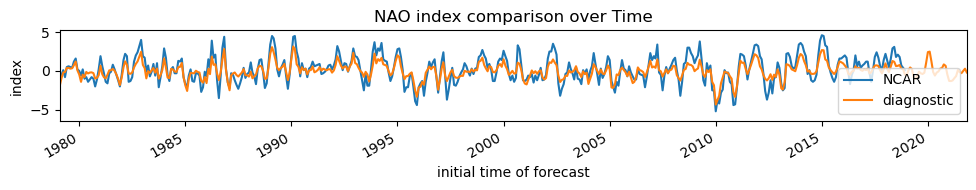

In [14]:
time_vals = np.array(time.values)

# Convert to datetime objects
datetimes = [np.datetime64(t).astype(datetime.datetime) for t in time_vals]

# Plot with matplotlib
fig = plt.figure(figsize=(10,2))
plt.plot(datetimes, nao_ncar.values,label='NCAR')

plt.xlim(datetime.datetime(1979, 1, 31, 0, 0),datetime.datetime(2021, 10, 31, 0, 0))
#plt.ylim(-5,+5)

nao.plot(label='diagnostic')
plt.legend()
plt.title('NAO index comparison over Time')
fig.tight_layout()
plt.savefig('img/NAO_ncar.png')
plt.show()